In [ ]:
pip install transformers==4.45.2 sentence-transformers==3.1.1 datasets evaluate

In [2]:
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score,
    recall_score, f1_score,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from imblearn.over_sampling import RandomOverSampler
from peft import PeftModel, LoraConfig, get_peft_model
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.nn import functional as F
from imblearn.over_sampling import SMOTE

In [4]:
companies = pd.read_csv('companies.csv')
#companies

In [5]:
companies['Success'] = ((companies['Was Acquired'] == 1) |
                   (companies['IPO'] == 1) |
                   (companies['High Funding'] == 1)).astype(int)

# concat columns that are exploded
def concatenate_columns(df, column_prefix, new_column_name):
    columns_to_combine = [col for col in df.columns if col.startswith(column_prefix)]

    # Function to concatenate the column names where the value is 1
    def concatenate_values(row, cols):
        values = [col.replace(column_prefix, '') for col in cols if row[col] == 1]
        return ', '.join(values)

    df[new_column_name] = df.apply(lambda row: concatenate_values(row, columns_to_combine), axis=1)
    df = df.drop(columns=columns_to_combine)

    return df


companies = concatenate_columns(companies, column_prefix='Industry_', new_column_name='Industry')
companies = concatenate_columns(companies, column_prefix='Investor Country_', new_column_name='Investor Country')


# fill all 0 values with NaN
companies = companies.replace(0, np.nan)
companies['Success'] = companies['Success'].fillna(0)

In [6]:
model_id = "distilbert/distilbert-base-uncased"
id2label = {0: "No-Success", 1: "Success"}
label2id = {"No-Success": 0, "Success": 1}

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id, add_prefix_space=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=2, id2label=id2label, label2id=label2id
)

# Load and preprocess data
excluded_cols = ['Was Acquired', 'IPO', 'HighFunding', 'Success', 'Description', 'LinkedIn', 'Twitter', 'ID', 'Website',
                 'Project Funding', 'Startup Funding', 'Growth Funding', 'Expansion Funding', 'Exit Funding', 'Company ID',
                 'Facebook', 'Industry']

full_prompts = []
for _, row in companies.iterrows():
    eligible_cols = [col for col in companies.columns if col not in excluded_cols]
    details = [f"{col}: {row[col]}" for col in eligible_cols if pd.notna(row[col])]
    input_text = "Company Details: " + "; ".join(details) + ". Predict Success"
    full_prompts.append({"text": input_text.replace("\n", ""), "label": int(row['Success'])})

full_prompts = pd.DataFrame(full_prompts)

#all_combs = pd.concat([random_pairs, full_prompts], ignore_index=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Split dataset into train and test
# prec: 0.953846 with [max_length 256; lr: 1e-4; weighted_loss: 5.0]
# prec:  with [max_length 128; lr: 5e-4; weighted_loss: 5.0]

train, test = train_test_split(full_prompts, test_size=0.4, stratify=full_prompts["label"])

# prec: 0.918467 with [max_length 256; lr: 1e-4; weighted_loss: 5.0]
#train, test = train_test_split(full_prompts, test_size=0.3, stratify=full_prompts["label"])

# Tokenize the training texts
X_train = train['text'].tolist()
y_train = train['label'].tolist()

# Tokenize the inputs and extract attention masks
tokenized_train = tokenizer(
    X_train,
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="np"
)

input_ids = tokenized_train['input_ids']
attention_mask = tokenized_train['attention_mask']

# Combine input_ids and labels for SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(input_ids, y_train)

# Align attention_mask with resampled input_ids
attention_mask_resampled = attention_mask[X_resampled[:, 0]]  # Use resampled indices from SMOTE

# Create a balanced training dataset dictionary
train_balanced = {
    "input_ids": X_resampled,
    "attention_mask": attention_mask_resampled,
    "label": y_resampled
}

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict(train_balanced)

# Tokenize test dataset
tokenized_test = tokenizer(
    test['text'].tolist(),
    truncation=True,
    padding="max_length",
    max_length=256,
    return_tensors="np"
)

test_dataset = Dataset.from_dict({
    "input_ids": tokenized_test['input_ids'],
    "attention_mask": tokenized_test['attention_mask'],
    "label": test['label'].tolist()
})

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [8]:
# Compute precision-based metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    precision = precision_score(labels, predictions, pos_label=1)
    recall = recall_score(labels, predictions, pos_label=1)
    f1 = f1_score(labels, predictions, pos_label=1)

    return {"precision": precision, "recall": recall, "f1": f1, "main_metric": precision}  # Prioritize precision

# PEFT configuration
peft_config = LoraConfig(
    task_type="SEQ_CLS",
    r=16,
    lora_alpha=32,
    lora_dropout=0.2,
    target_modules=['q_lin']
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Training arguments with precision as the primary metric
training_args = TrainingArguments(
    output_dir=model_id + "-lora-text-classification",
    learning_rate=5e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="main_metric",  # Use precision as the evaluation metric
    greater_is_better=True,
    report_to="none"
)

# Custom trainer with weighted loss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        logits = logits[:, 1]

        # Apply a weighted loss to emphasize precision
        pos_weight = torch.tensor([5.0]).to(logits.device)  # Adjust the weight as necessary
        loss = F.binary_cross_entropy_with_logits(logits, labels.float(), pos_weight=pos_weight)

        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate and adjust threshold to maximize precision
raw_predictions = trainer.predict(test_dataset)
y_probs = torch.nn.functional.softmax(torch.tensor(raw_predictions.predictions), dim=1)[:, 1].numpy()
labels = raw_predictions.label_ids
precision, recall, thresholds = precision_recall_curve(labels, y_probs)

# Find the optimal threshold based on precision-recall tradeoff
optimal_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall))]
predictions = (y_probs > optimal_threshold).astype(int)

# Show the optimal threshold and resulting precision
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Precision at Optimal Threshold: {precision[np.argmax(2 * (precision * recall) / (precision + recall))]}")


trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Main Metric
1,No log,1.202936,0.174779,1.000000,0.297552,0.174779
2,No log,1.129999,0.337349,0.354430,0.345679,0.337349
3,No log,0.840725,0.718750,0.582278,0.643357,0.718750
4,No log,0.927409,1.000000,0.531646,0.694215,1.000000
5,0.687900,0.900736,1.000000,0.531646,0.694215,1.000000
6,0.687900,0.926266,1.000000,0.531646,0.694215,1.000000
7,0.687900,0.894099,1.000000,0.531646,0.694215,1.000000
8,0.687900,1.030225,1.000000,0.531646,0.694215,1.000000
9,0.687900,0.927684,1.000000,0.531646,0.694215,1.000000
10,0.492800,0.918467,1.000000,0.544304,0.704918,1.000000


Optimal Threshold: 0.2566644549369812
Precision at Optimal Threshold: 0.8135593220338984


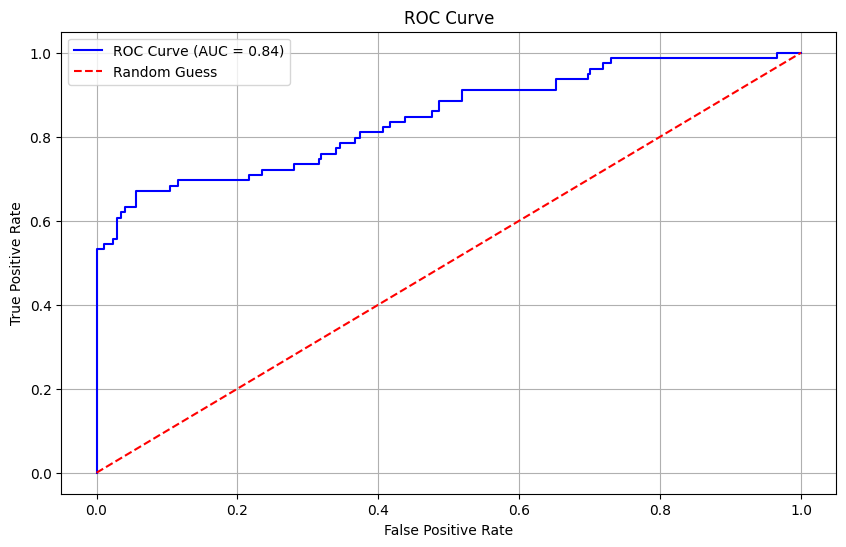

In [9]:
fpr, tpr, _ = roc_curve(labels, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

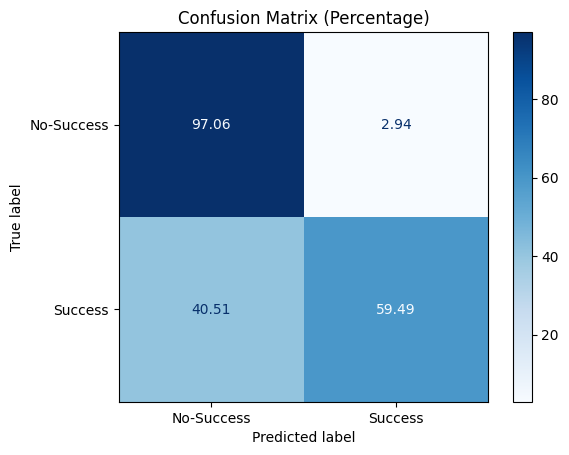

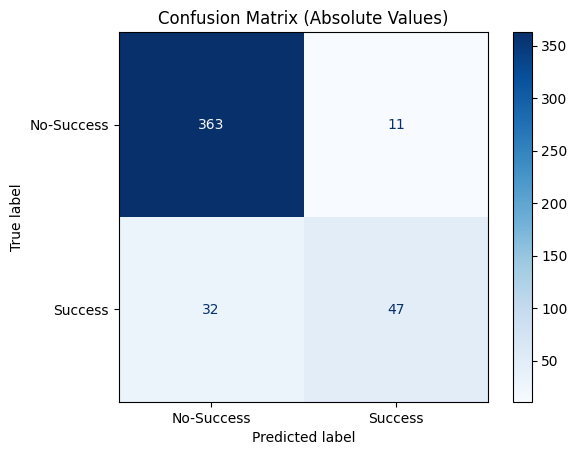

In [10]:
# Confusion matrix
cm = confusion_matrix(labels, predictions, labels=[0, 1])
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cmd = ConfusionMatrixDisplay(cm_percentage, display_labels=["No-Success", "Success"])
cmd.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Absolute Confusion Matrix
cmd_abs = ConfusionMatrixDisplay(cm, display_labels=["No-Success", "Success"])
cmd_abs.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix (Absolute Values)")
plt.show()
